# Mestrado Prossional de Economia INSPER - Turma MPE16
# Trabalho de conclusão do curso de Finanças Quantitativas (2020.1)

#### Autores: Ciro Aloísio de Paula Duarte, João Italo Zecchin Reis, Robert Aldo Andreotti Filho 


#### O relatório do trabalho está separado em dois arquivos de Jupyter Notebook:
    Parte 1: Desenvolvimento dos trackers e dos sinais de momentum, value e carry das moedas analisadas contra o dólar americano.
    Parte 2: Criação da estratégia de trading e realização do backtest.

##    
## PARTE 2 
##   

## Resumo

O objetivo do trabalho é criarmos uma estratégia de pair trading entre moedas de um mesmo bloco econômico de modo que faça sentido a comparação entre elas duas a duas. 

A proposta deste segundo jupyter notebook é desenvolvermos uma estratégia de trading baseado nos sinais de momentum, value e carry produzidos na parte 1 do trabalho. Para tal, elaboramos uma regressão logística e um modelo de classificação KNN que indica de forma binária se o retorno do ativo será positivo ou negativo e em seguida calculamos a probabilidade de termos no futuro um bull market. 

Por fim, usamos os sinais criados pelo modelo KNN, que teve melhor desempenho que a regrressaão logísitca, para realizarmos um backtest para a parte do período que não foi considerado no treinamento.

In [1]:
#import das bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

###   
#### Definição das moedas usadas na estratégia
Para executarmos nossa estratégia de trading decidimos separar as moedas em três grupos, cada qual com uma característica econômica para então fazermos o pair trading entre todas as moedas de uma mesma cesta:

Para nosso projeto separamos três blocos:

    - Moedas de países da Europa (EUR, GBP e SEK); 
    - Moedas de países relevantes em commodities (AUD, CAD, NOK e ZND);
    - Moedas de países emergentes (BRL, MXN e ZAR);

In [2]:
#inicialização das listas dos blocos para evitar que em novas execuções do código possa ter lixo na memória
europe = []
cmdty = []
EM = []

#definição dos blocos de moedas em listas
europe = ['EUR', 'GBP', 'SEK']
cmdty = ['AUD', 'CAD', 'NOK', 'NZD']
EM = ['BRL', 'MXN', 'ZAR']

basket = [europe, cmdty, EM]
basket_names = ['Europe', 'Commodity Countries', 'Emerging Market']

#### Leitura dos trackers e dos sinais desenvolvidos na parte 1 do projeto paro uso neste Jupyter Notebook


In [3]:
#Todos os arquivos em excel devem na mesma pasta que este jupyter notebook
mom_df = pd.read_excel('momentum.xlsx',index_col=0)
value_df = pd.read_excel('value.xlsx',index_col=0)
carry_df = pd.read_excel('carry.xlsx',index_col=0)
trackers_df = pd.read_excel('trackers.xlsx',index_col=0)


#### Criação dos sinais com os retornos das moedas ao longo do tempo

In [4]:
#consideramos o retornos mensais, aproximadamente 21 dias úteis
h = 21 
#Note que o uso do método .shift(-h) no datframe garante que teremos no index t o retorno de t até t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()

##    
## Estratégia

Nesta sessão desenvolvemos dois modelos de classificação baseados nos sinais de entrada momentum, carry e value.

Implementamos a regressão logística, mais básica e mais popularmente conhecida, e a K-Neartest Neighbors (KNN), mais robusta, que consiste em um modelo não linear que identifica as K observaões passadas mais próximas a atual e classifica a uma classe mais próvável de acordo com a regra de Bayes. Para ambas, o resultado é binário e indica se o retorno esperado é positivo ou negativo.

Posto isso, usamos nossos modelos para predizerem se a probabilidade dos pares das moedas contra o dólar terão retornos positivos ou negativos e dependendo desse resultado, decidiremos comprar, vender ou manter o ativo em nosso book.

Como o KNN obeteve melhor desempenho, como esperado pela literatura, usamos ele como modelo base para nosso backtest.

Em relação ao período, treinamos nossos modelos inicialmente por aproximadamente 3 anos (3x252 dias) e a partir de então, para cada novo dia geramos uma nova estimação do modelo apenas os dados passados atualizados e a respectiva previsão com os dados mais recentes.

Ademais,importante salientar que foi desenvolvido um modelo para cada par de moedas.

In [5]:

import statsmodels.api as sm
signal = pd.DataFrame()
signal_knn = pd.DataFrame()

n = 5
for ccy in trackers_df.columns:
    print('Running currency %s' % ccy, end="\r")
    y = (1*(returns_df[ccy]>=0)).to_frame('returns')
    
    #padronização dos sinais
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    
    #garante alnhamento dos sinais e preencha as nan's com a última observação, caso haja alguma
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    X = sm.add_constant(X)
    
    #garante padronização das datas dos sinais e dos retornos futuros
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    
    X_with_interactions = PolynomialFeatures(interaction_only=True)
    X_with_interactions.fit_transform(X)
    features = X_with_interactions.get_feature_names(X.columns)
    features[0] = 'const'
    X_with_interactions = X_with_interactions.fit_transform(X)
    X_with_interactions = pd.DataFrame(index=X.index,data=X_with_interactions,columns=features).drop('const',1)
    yX_knn = pd.concat([y,X_with_interactions.shift(1).dropna()],axis=1,sort=True).dropna()
    
    neigh = KNeighborsClassifier(n_neighbors=n)    
    prob_market_going_up = pd.Series(index=yX.index[3*252:])
    prob_market_going_up_knn = pd.DataFrame()
    
    #loop ao longo dos dias
    for d in prob_market_going_up.index:

        #adquire os dados do passado para o cálculo do sinal
        past_returns_indicator = yX.iloc[:,0].loc[:d]
        past_features = yX.iloc[:,1:].loc[:d]
        past_returns_indicator_knn = yX_knn.iloc[:,0].loc[:d]
        past_features_knn = yX_knn.iloc[:,1:].loc[:d]
        
        #ajusta o modelo usando o Logit, mas não usa as últimas h observações para garantir que estamos usando o conjunto de informações correto
        model = sm.Logit(past_returns_indicator.shift(h).dropna(), past_features.shift(h).dropna()).fit(disp=False)
        neigh.fit(past_features_knn, past_returns_indicator_knn)

        #usando as informações atuais para predizer o mercado
        current_features = past_features.ewm(halflife=63).mean().iloc[-1] # note here the EWMA smoothing here
        current_features_knn = X_with_interactions.loc[:d].iloc[-1].values
        prob_market_going_up[d]= model.predict([current_features])[0]
        prob_market_going_up_knn[d] = neigh.predict_proba([current_features_knn])[0]
    
    signal = pd.concat([signal,prob_market_going_up.to_frame(ccy)],join='outer',axis=1,sort=True)
    signal_knn = pd.concat([signal_knn,prob_market_going_up_knn.iloc[1,:].to_frame(ccy)],join='outer',axis=1,sort=True)

signal = signal.fillna(method='ffill')
signal_knn = signal_knn.fillna(method='ffill')

C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\beto0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###   
Como os sinais do KNN são discretos e se só assumem valores multiplos de 10 bps, por meio do gráfico não se nenhuma infomarção legível. Por isso, segue abaixo apenas o head da tabela para efeitos didáticos de representação.

In [6]:
signal_knn.head()

,EURUSD,GBPUSD,SEKUSD,AUDUSD,CADUSD,NOKUSD,NZDUSD,BRLUSD,MXNUSD,ZARUSD
2013-11-11,0.4,0.8,0.6,1.0,0.2,0.6,0.2,0.6,0.6,0.6
2013-11-12,1.0,0.2,0.6,0.8,0.2,0.6,0.4,0.4,0.6,0.8
2013-11-13,0.4,0.6,0.4,1.0,0.6,1.0,0.4,0.6,0.4,0.8
2013-11-14,1.0,0.6,0.6,0.6,0.4,0.6,0.0,0.2,0.4,0.4
2013-11-15,0.8,0.8,0.4,0.6,0.4,0.6,0.4,0.0,0.6,0.0


###   
Por outro lado, o sinal da regressão logística é continuo:

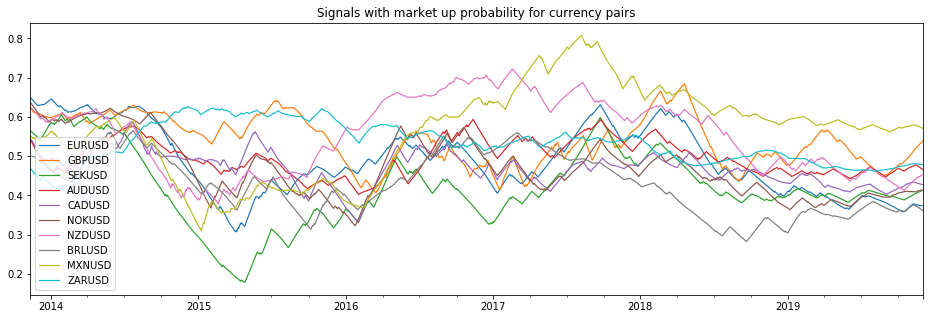

In [7]:
signal.plot(title='Signals with market up probability for currency pairs',figsize=(16,5), linewidth=1.2)
plt.show()

##   
## Backtest

Para realização do backtest, finalmente fizemos o cross currency entre as moedas que fazem parte de um mesmo grupo econômico. Diante disso, não comparamos, por exemplo, BRL que é uma moeda de um país emergente contra GBP que pertence a um país desenvolvido da europa.

O nosso critério para realizarmos trading é a diferença entre a probabilidade de alta do par de moedas ser maior que 5 bps, assim ficariamos long na com maior probabilidade e short na de menor. Como os sinais do KNN variam de múltiplos de 10 bps, só nessitamos que o sinal não seja igual para fazermos o pair trading.

Na função abaixo retormanos o dataframe com o backtest de todas a moedas de uma mesma cesta. De início, definimos 100 unidades monetárias como o valor inicial a serem usados na nossa simulação e para cada semana do nosso período de teste podemos rebalancear os ativos de modo a ajustarmos os holdings por 40% de vol ewma. Além disso, como se trata de um pair tarding, as posições long e short devem ser iguais.

In [8]:
#função que retorna um datframe contendo o backtest para cada um pares 
#contidos na lista parâmetro de entrada 'group'
def backtest_by_group(group, trackers_df, signal, pairs):  
    
    trackers_df = trackers_df.fillna(method='ffill')
    backtest = pd.DataFrame(index=signal.index, columns = pairs)

    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]

        pair1 = ccy1+'USD'
        pair2 = ccy2+'USD'

        backtest[ccy1+ccy2].iloc[0] = 100 # initialize the backtest with 100
        start_date = signal.index[0]

        # first trade
        vols_ccy1 = np.log(trackers_df[pair1].loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        vols_ccy2 = np.log(trackers_df[pair2].loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        positions_ccy1 = 1*(signal[pair1].iloc[0] - signal[pair2].iloc[0]>0.05) + -1*(signal[pair2].iloc[0] - signal[pair1].iloc[0]>0.05)
        positions_ccy2 = -1*positions_ccy1
        prices_ccy1 = trackers_df[pair1].loc[:start_date].iloc[-1]
        prices_ccy2 = trackers_df[pair2].loc[:start_date].iloc[-1]
        holdings_ccy1 = ((0.4/vols_ccy1.iloc[-2])*positions_ccy1)*(backtest[ccy1+ccy2].iloc[0]/prices_ccy1)
        holdings_ccy2 = ((0.4/vols_ccy2.iloc[-2])*positions_ccy2)*(backtest[ccy1+ccy2].iloc[0]/prices_ccy2)
        if positions_ccy1 == -1:
            holdings_ccy2 = holdings_ccy1
        else:
            holdings_ccy1 = holdings_ccy2

        print('Running currency ' + ccy1 + ccy2, end="\r")

        # loop over the next days
        for i in range(1,len(signal)): # loop over all the signals
            tdy = signal[pair1].index[i]
            yst = signal[pair1].index[i-1]

            # calculate pnl on the day
            price_change_ccy1 = trackers_df[pair1].loc[:tdy].iloc[-1] - trackers_df[pair1].loc[:yst].iloc[-1]
            price_change_ccy2 = trackers_df[pair2].loc[:tdy].iloc[-1] - trackers_df[pair2].loc[:yst].iloc[-1]
            pnl_ccy1 = (holdings_ccy1*price_change_ccy1).mean()
            pnl_ccy2 = (holdings_ccy2*price_change_ccy2).mean()
            backtest[ccy1+ccy2].iloc[i] = backtest[ccy1+ccy2].iloc[i-1] + pnl_ccy1 + pnl_ccy2

            if tdy.week != yst.week: # check if it's a new week and reasses trades if so        
                vols_ccy1 = np.log(trackers_df[pair1].loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
                vols_ccy2 = np.log(trackers_df[pair2].loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
                positions_ccy1 = 1*(-signal[pair1].iloc[i] + signal[pair2].iloc[i]>0.05) + -1*(-signal[pair2].iloc[i] + signal[pair1].iloc[i]>0.05)
                positions_ccy2 = -1*positions_ccy1
                prices_ccy1 = trackers_df[pair1].loc[:tdy].iloc[-1]
                prices_ccy2 = trackers_df[pair2].loc[:tdy].iloc[-1]
                holdings_ccy1 = ((0.4/vols_ccy1.iloc[-2])*positions_ccy1)*(backtest[ccy1+ccy2].iloc[i]/prices_ccy1)
                holdings_ccy2 = ((0.4/vols_ccy2.iloc[-2])*positions_ccy2)*(backtest[ccy1+ccy2].iloc[i]/prices_ccy2)
                if positions_ccy1 == -1:
                    holdings_ccy2 = holdings_ccy1
                else:
                    holdings_ccy1 = holdings_ccy2

    return backtest


##    
A função abaixo retorna o resultado retorna a média arimética do pnl de cada backtest.

In [9]:
def avg_backtest(backtest, pairs, col_name):    
    backtest[col_name] = 0
    for pair in pairs:
        backtest[col_name] = backtest[col_name] + backtest[pair]
    backtest[col_name] = backtest[col_name]/len(pairs)
    return backtest[col_name]

#### Backtesting separado por bloco econômico
* Eurupe: o backtest dos três pares do grupo tiveram uma correlação média entre si revelando que a estratégia aparenta funcionar de forma semelhante, porém até o início de 2015 o retorno do pair trading EURSEK descolou consideravelmente em relação ao resto da cesta. Após isso, houve uma  redução no pnl até retornar aos pataremos dos outros pares.
* Cmdty: nota-se que o trading dos pares AUDCAD, AUDNOK, AUDNZD e NOKNZD tiveram uma performance semelhante durante todo o backtesting, de modo que no longo prazo percebeu-se uma estabilização em torno do pnl inicial, por isso concluímos que a estratégia não teve o resultado esperado. Por outro lado, para CADNOK e CADNZD vimos que a partir da metade de 2015 ocorreu um outperform desses pares em relação ao resto da cesta.
* EM: destaque do grupo ficou por conta do pair trading de BRLMXN que teve um desempenho muito superior a partir do segundo ano de backtesting até o final. Já para os pares que têm ZAR, tivemos resultados fracos.



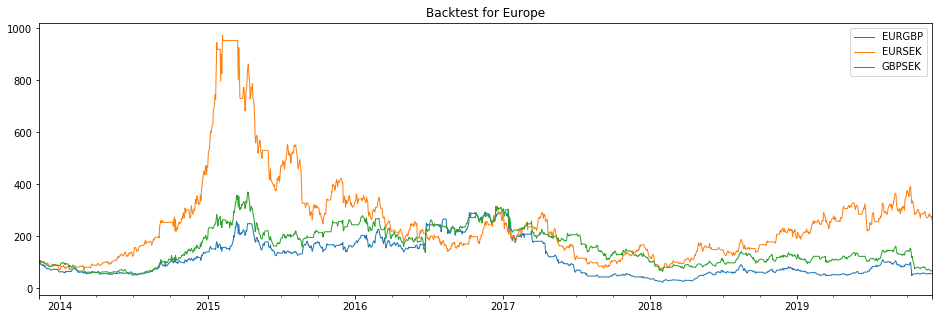

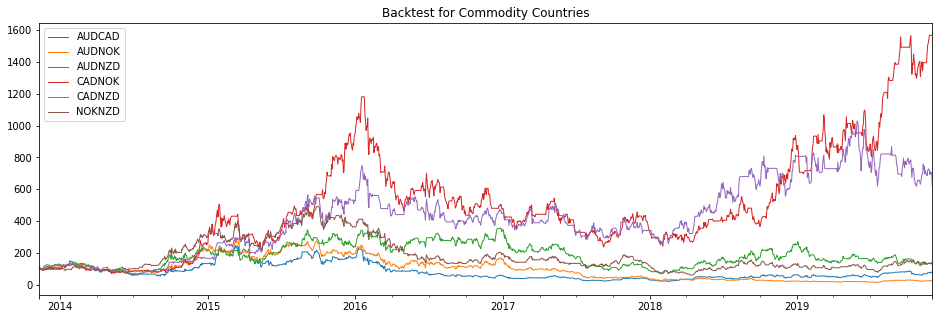

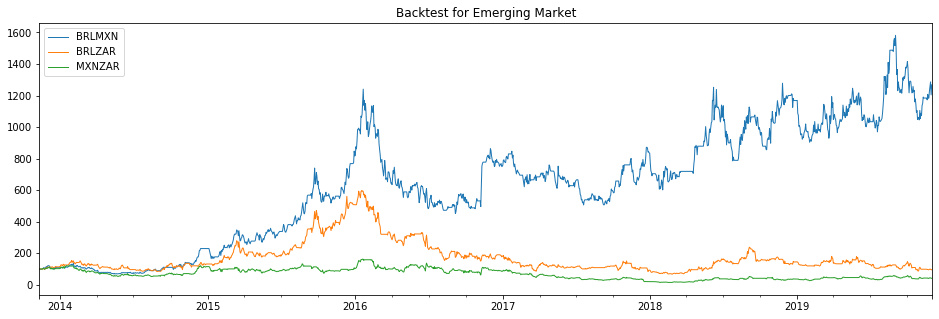

In [10]:
#inicializações
backtest_tot = pd.DataFrame()
group_num = -1

#loop com backtest de cada bloco econômico em separado
for group in basket:
   
    #inicializações e atualizações ára cada etapa do loop
    pairs = []
    group_num = group_num + 1
    backtest_group = pd.DataFrame()
    
    #combinação de todas as moedas de um memso grupo
    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]
        pairs.append(ccy1+ccy2)    
    
    #backtesting
    backtest_group = backtest_by_group(group, trackers_df, signal_knn, pairs)
    backtest_group.plot(title='Backtest for ' + basket_names[group_num],figsize=(16,5), linewidth=1)
    plt.show()
    backtest_tot = backtest_tot.append(avg_backtest(backtest_group, pairs, basket_names[group_num]))

#### Backtesting comparando os blocos
Na metade do período de backtesting percebeu-se uma variação considerável na performance dos tradings de cada grupo, porém na outra metade, o grupo com moedas de países europeus teve um declínio no desempenho implicando numa queda do backtesting global, enquanto moedas relacionadas a países emergentes e os relevantes em commodities obtiveram um resultado bastante satisfatório.

Importante comentar que embora tenhamos percebido desempenhos fracos para alguns pair tradings, em nenhum momento ficamos consideralvemete abaixo do pnl inicial. Em contrapartida, por vários momentos, tivemos pnl bem acima do valor começado.

Portanto, destacmos os princiapis destaques positivos: BRLMXN e CADNOK.

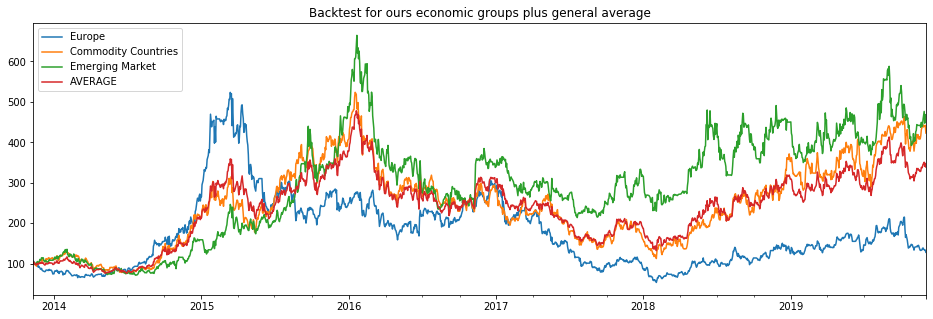

In [11]:
backtest_tot_groups = backtest_tot.T
backtest_tot_groups.append(avg_backtest(backtest_tot_groups, basket_names, "AVERAGE"))
backtest_tot_groups.plot(title='Backtest for ours economic groups plus general average',figsize=(16,5), linewidth=1.5)
plt.show()

### Comparação entre os dois modelos

Para comparar a eficiência dos dois modelos em relação a previsibilidade dos retornos futuros, calculamos os percentuais de erros e de acertos para cada moeda em cada um dos modelos.

Podemos observar pela tabela abaixo que o KNN tem um percentual de acerto (considerando os true positives e true negatives) sempre maior que a regressão logística. Podemos observar também que para todas as moedas o KNN tem sempre um percentaual de acerto maior que o de erros, o que não ocorre na regressão logística, que para alguns casos o percentual de erro é maior que o percentual de acertos.

In [30]:
matriz_final = pd.DataFrame(columns = ['Currency', 'Percentual', 'Criteria', 'Method'])
for ccy in trackers_df.columns:

    y = 1*(np.sign(returns_df[[ccy]])>=0)
    prediction = 1*(np.sign(signal[[ccy]] - 0.5)>0)
    prediction_knn = 1*(np.sign(signal_knn[[ccy]] - 0.5)>0)
    
    matriz = pd.concat([prediction,y],join='inner',axis=1,sort=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Percentual': (confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,1) +
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,0)) /
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).sum(),
                                        'Criteria': '% acerto',
                                        'Method': 'Logistic'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Percentual': (confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,1) +
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,0)) /
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).sum(),
                                        'Criteria': '% erro',
                                        'Method': 'Logistic'}, ignore_index=True)

    matriz = pd.concat([prediction_knn,y],join='inner',axis=1,sort=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Percentual': (confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,1) +
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,0)) /
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).sum(),
                                        'Criteria': '% acerto',
                                        'Method': 'KNN'}, ignore_index=True)
    matriz_final = matriz_final.append({'Currency': ccy,
                                        'Percentual': (confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,1) +
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,0)) /
                                        confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).sum(),
                                        'Criteria': '% erro',
                                        'Method': 'KNN'}, ignore_index=True)

table = pd.pivot_table(matriz_final, values=['Percentual'], index=['Currency'],
                    columns=['Method', 'Criteria'], aggfunc=np.sum)
table

Percentual                              
Method          KNN            Logistic          
Criteria   % acerto    % erro  % acerto    % erro
Currency                                         
AUDUSD     0.581910  0.418090  0.471853  0.528147
BRLUSD     0.664137  0.335863  0.534472  0.465528
CADUSD     0.592663  0.407337  0.500316  0.499684
EURUSD     0.609108  0.390892  0.497786  0.502214
GBPUSD     0.583808  0.416192  0.440860  0.559140
MXNUSD     0.612271  0.387729  0.557242  0.442758
NOKUSD     0.592663  0.407337  0.485136  0.514864
NZDUSD     0.575585  0.424415  0.528147  0.471853
SEKUSD     0.613536  0.386464  0.513599  0.486401
ZARUSD     0.641366  0.358634  0.548387  0.451613